<center>  <h1> SQwash: Distributionally Robust Learning in PyTorch with 1 Additional Line of Code </h1> </center>
<center> Krishna Pillutla, Yassine Laguel, Jérôme Malick, Zaid Harchaoui </center>

In this notebook we demonstrate how the SQwash package can be used to train distributionally robust models in PyTorch with one additional line of code using the CIFAR-10 dataset. 

## 1. Define the model
We start by defining a simple convolutional neural network. 

In [1]:
import torch
import torch.nn as nn
torch.manual_seed(0)
import random
random.seed(1)

output_sizes_dict = {1: 16, 2: 8}

class ConvCifar(nn.Module):
    def __init__(self, num_classes=10, num_layers=5, num_channels=256):
        super().__init__()
        lst = [nn.Conv2d(3, num_channels, 3, padding=1, stride=2)]
        for i in range(1, num_layers):
            stride = 2 if i < 3 else 1 # stride the first three convolutions
            lst.append(nn.Conv2d(num_channels, num_channels, 3, padding=1, stride=stride))
            lst.append(nn.ReLU(inplace=True))
        self.features = nn.Sequential(*lst)
        assert num_layers >= 1
        output_size = output_sizes_dict.get(num_layers, 4)
        self.classifier = nn.Linear(num_channels * output_size * output_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
net = ConvCifar().to(device)

## 2. Load the data

Let us load the CIFAR-10 dataset and the corresponding dataloader. For details, see [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [3]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Let us write a simple function to calculate the test accuracy of the model. 

In [4]:
@torch.no_grad()
def compute_accuracy(net, dataloader):
    correct = 0
    total = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = net(x)
        correct += (pred.argmax(axis=1) == y).sum().item()
        total += pred.shape[0]
    return correct / total
print('Accuracy at initialization =', compute_accuracy(net, testloader)*100, '%')

Accuracy at initialization = 10.0 %


## 3. Train a model with the cross entropy loss (usual training)
Let us write out a simple training loop to train this model with the cross entropy loss. This code is taken from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). 

In [5]:
import time

net = ConvCifar().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.04, momentum=0.0)

logs = []  # test accuracy

print('Epoch\tTrain Loss\tTest Accuracy\tTime')

for epoch in range(40):  # loop over the dataset multiple times
    running_loss = 0.0
    start_time = time.time()
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device) 
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = net(x)
        loss = criterion(outputs, y)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        # Statistics
        running_loss = running_loss * i / (i+1) + loss.item() / (i+1)
    logs.append(compute_accuracy(net, testloader))
    print(f'{epoch+1}\t{running_loss:.2f}\t\t{100 * logs[-1]:.2f}%', 
          f'\t\t{round(time.time() - start_time, 2)}s')



Epoch	Train Loss	Test Accuracy	Time
1	1.97		37.60% 		9.12s
2	1.55		49.65% 		8.89s
3	1.36		52.28% 		8.65s
4	1.24		57.01% 		8.72s
5	1.14		58.52% 		9.06s
6	1.04		61.80% 		9.38s
7	0.95		61.47% 		9.49s
8	0.86		64.08% 		9.01s
9	0.78		65.06% 		9.38s
10	0.69		63.04% 		9.2s
11	0.60		65.86% 		9.07s
12	0.51		66.59% 		9.53s
13	0.42		66.72% 		9.43s
14	0.33		66.91% 		9.96s
15	0.25		66.53% 		9.1s
16	0.18		65.40% 		9.14s
17	0.12		67.83% 		8.94s
18	0.07		67.28% 		8.61s
19	0.06		67.68% 		8.63s
20	0.04		68.14% 		9.05s
21	0.03		68.12% 		9.51s
22	0.01		69.42% 		9.79s
23	0.00		69.73% 		9.8s
24	0.00		69.87% 		9.63s
25	0.00		69.95% 		9.85s
26	0.00		69.94% 		9.39s
27	0.00		70.05% 		9.38s
28	0.00		69.96% 		9.29s
29	0.00		70.05% 		9.55s
30	0.00		69.92% 		8.84s
31	0.00		70.08% 		8.55s
32	0.00		69.94% 		8.8s
33	0.00		70.01% 		9.15s
34	0.00		69.93% 		9.28s
35	0.00		69.94% 		9.52s
36	0.00		69.92% 		9.37s
37	0.00		70.00% 		9.63s
38	0.00		69.95% 		9.05s
39	0.00		70.03% 		9.06s
40	0.00		70.04% 		9.84s


## 4. Train the same model to be distributionally robust using `sqwash`

To get distributional robustness with `sqwash`, we only need to start by
- defining the `SuperquantileReducer`, and,
- setting `reduction='none'` in the criterion. 

With this in place, the 1 additional line we need to make to our training loop is 
- reduce the losses with the `SuperquantileReducer` object defined above. 

In [6]:
from sqwash import SuperquantileReducer

net = ConvCifar().to(device)
reducer = SuperquantileReducer(superquantile_tail_fraction=0.6)  # keep 60% of the worst losses in each batch
criterion = torch.nn.CrossEntropyLoss(reduction='none')  # NOTE: set reduction='none' so that we get the batch losses
optimizer = torch.optim.SGD(net.parameters(), lr=0.04, momentum=0.0)

logs_sq = []  # test accuracy

print('Epoch\tTrain Loss\tTest Accuracy\tTime')

for epoch in range(40):  # loop over the dataset multiple times
    running_loss = 0.0
    start_time = time.time()
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device) 
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = net(x)
        batch_loss = criterion(outputs, y)
        loss = reducer(batch_loss)  # The 1 additional line to reduce batch losses using the superquantile
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        # Statistics
        running_loss = running_loss * i / (i+1) + loss.item() / (i+1)
    logs_sq.append(compute_accuracy(net, testloader))
    print(f'{epoch+1}\t{running_loss:.2f}\t\t{100 * logs_sq[-1]:.2f}%', 
          f'\t\t{round(time.time() - start_time, 2)}s')


Epoch	Train Loss	Test Accuracy	Time
1	2.27		33.41% 		9.67s
2	2.06		40.29% 		9.48s
3	1.90		48.27% 		9.44s
4	1.80		53.66% 		9.16s
5	1.70		53.76% 		8.89s
6	1.59		54.94% 		8.61s
7	1.49		60.92% 		9.09s
8	1.38		62.49% 		9.15s
9	1.27		64.47% 		9.48s
10	1.15		64.37% 		9.91s
11	1.00		64.73% 		9.49s
12	0.86		65.20% 		9.69s
13	0.69		67.09% 		9.49s
14	0.52		66.46% 		9.49s
15	0.37		66.40% 		9.73s
16	0.25		66.41% 		9.41s
17	0.18		66.97% 		9.41s
18	0.13		68.14% 		8.72s
19	0.10		63.97% 		8.94s
20	0.08		67.49% 		9.27s
21	0.06		67.75% 		9.05s
22	0.05		67.44% 		9.33s
23	0.03		68.72% 		9.88s
24	0.03		68.82% 		9.4s
25	0.04		68.08% 		9.48s
26	0.03		68.11% 		8.9s
27	0.01		68.89% 		9.45s
28	0.00		69.87% 		9.64s
29	0.00		70.34% 		9.63s
30	0.00		70.45% 		9.7s
31	0.00		70.55% 		9.18s
32	0.00		70.56% 		9.39s
33	0.00		70.46% 		8.88s
34	0.00		70.53% 		8.97s
35	0.00		70.56% 		9.19s
36	0.00		70.54% 		9.0s
37	0.00		70.54% 		9.54s
38	0.00		70.55% 		9.67s
39	0.00		70.50% 		9.76s
40	0.00		70.46% 		9.44s


## Make a plot to visualize the test loss
Let us plot the average test loss for regular training and the distributionally robust training.

(0.6, 0.71)

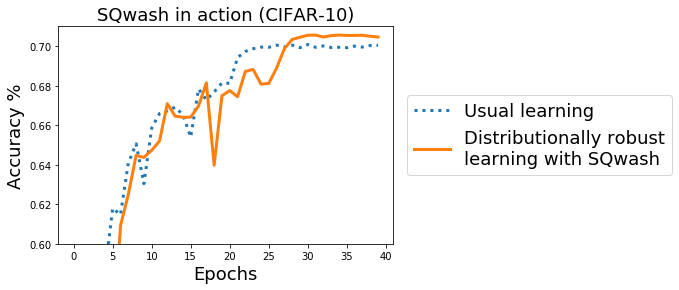

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(logs, label='Usual learning', linewidth=3, linestyle='dotted')
plt.plot(logs_sq, label='Distributionally robust\nlearning with SQwash', linewidth=3, linestyle='solid')
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy %', fontsize=18)
plt.title('SQwash in action (CIFAR-10)', fontsize=18)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=18)
plt.ylim((0.6, 0.71))

More generally, we find that distributionally robust learning with the superquantile helps with improving the performance on the worst-performing subgroups of data. The following figure, taken from [this paper](https://ieeexplore.ieee.org/document/9400318) illustrates this for the case of distributed training of machine learning models on mobile devices (a.k.a. federated learning)

![](../fig/usual_vs_sq.png)

From this historgram of the misclassification error (= 1 - Accuracy), we see that the right tail is thinner for the `SQ`, which is based on distributionally robust learning with the superquantile. 

This denotes smaller misclassification error on the subgroups of data with the worst performance. 